### bibliotecas

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import os
import yaml
import datetime
from datetime import date
import time
import configparser
import zipfile
import glob
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from selenium.webdriver.common.action_chains import ActionChains
import webbrowser

### manipulação de datas

In [ ]:
data_inicio_geral = '2023-08-31'
data_geral = '31-08'
data_geral2 = '31/08'
data_atual = datetime.datetime.now()
data_formatada = data_atual.strftime("%d-%m")
data_semana = data_atual - datetime.timedelta(days=7)
data_semana = data_semana.strftime("%Y-%m-%d")
data_semana2 = data_atual - datetime.timedelta(days=7)
data_semana2 = data_semana2.strftime('%d/%m')
data_atual2 = datetime.datetime.now()
data_formatada2 = data_atual.strftime("%d/%m")
pasta_destino = f"relatorio_{data_formatada}/data/"
assets = f"relatorio_{data_formatada}/assets/"

os.makedirs(pasta_destino, exist_ok=True)
os.makedirs(assets, exist_ok=True)



### extract dataprev

In [ ]:
url1 = "https://brasilparticipativo.presidencia.gov.br/admin/user_proposal_statistic_report/confjuv4"
url2 = "https://brasilparticipativo.presidencia.gov.br/open-data/download"

webbrowser.open(url1)
webbrowser.open(url2)


### extract dataprev

In [29]:
chrome_options = Options()
chrome_options.add_argument("--headless=new")
chrome_options.add_argument(f"--download.default_directory={os.path.abspath(pasta_destino)}")
chrome_options.add_experimental_option("prefs", {
    "download.prompt_for_download": False,
    "download.directory_upgrade": True,
    "safebrowsing.enabled": True
})
#chrome_options.add_argument("--start-fullscreen")
prefs = {
    "download.default_directory": os.path.abspath(pasta_destino),
    "download.prompt_for_download": False,
}
chrome_options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(options=chrome_options)

config = configparser.ConfigParser()
config.read('credentials.env')
user_dataprev = config.get('CREDENTIALS', 'USER_DATAPREV')
user_password = config.get('CREDENTIALS', 'PASSWORD_DATAPREV')

driver.get("https://ew.dataprev.gov.br/")

wait = WebDriverWait(driver, 3)
login_field = wait.until(EC.visibility_of_element_located((By.XPATH, '//input[@id="login_form_login"]')))
senha_field = wait.until(EC.visibility_of_element_located((By.XPATH, '//input[@id="login_form_password"]')))

login_field.send_keys(user_dataprev)
senha_field.send_keys(user_password)

entrar_button = driver.find_element(By.XPATH, '//input[@id="login_form_submit"]')
entrar_button.click()
time.sleep(5)
wait = WebDriverWait(driver, 3)
button = wait.until(EC.element_to_be_clickable((By.XPATH, '//span[text()="Todas as visitas"]')))

button.click()

cojuv_teste = wait.until(EC.element_to_be_clickable((By.XPATH, '//span[text()="Conjuv"]')))
cojuv_teste.click()
time.sleep(3)

data_element = wait.until(EC.element_to_be_clickable((By.ID, "date")))
data_element.click()

intervalo_element = wait.until(EC.element_to_be_clickable((By.XPATH, '//span[text()="intervalo de datas"]')))
intervalo_element.click()
time.sleep(2)
input_from = driver.find_element(By.ID, "inputCalendarFrom")
input_from.clear()
input_from.send_keys("2023-08-31")

data_atual = datetime.datetime.now()
data_atual = data_atual.strftime("%Y-%m-%d")

input_to = driver.find_element(By.ID, "inputCalendarTo")
input_to.clear()
input_to.send_keys(data_atual)

time.sleep(2)
aplicar_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//input[@id="calendarApply" and @value="Aplicar"]')))
aplicar_button.click()


export_buttons = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.dataTableAction.activateExportSelection")))

for export_button in export_buttons:
    report_title = export_button.get_attribute("report-title")
    if report_title == "Região":
        actions = ActionChains(driver)
        actions.move_to_element(export_button).perform()
        time.sleep(2)
        export_button.click()
        csv_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'CSV')]")))
        csv_element.click()
        format_metrics_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Métricas de formato')]")))
        format_metrics_element.click()
        todos_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Todos')]")))
        todos_element.click()
        export_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Exportar')]")))
        export_element.click()
        close_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[@class='ui-button-icon ui-icon ui-icon-closethick']")))
        close_button.click()
        time.sleep(2)
    
    if report_title == "Métricas principais":
        actions = ActionChains(driver)
        actions.move_to_element(export_button).perform()
        export_button.click()
        csv_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'CSV')]")))
        csv_element.click()
        format_metrics_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Métricas de formato')]")))
        format_metrics_element.click()
        todos_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Todos')]")))
        todos_element.click()
        export_link = wait.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Exportar')]")))
        export_link.click()
        close_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[@class='ui-button-icon ui-icon ui-icon-closethick']")))
        close_button.click()
        time.sleep(2)

    if report_title == "Tipo de dispositivo":
        actions = ActionChains(driver)
        actions.move_to_element(export_button).perform()
        export_button.click()
        csv_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'CSV')]")))
        csv_element.click()
        format_metrics_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Métricas de formato')]")))
        format_metrics_element.click()
        todos_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Todos')]")))
        todos_element.click()
        export_link = wait.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Exportar')]")))
        export_link.click()
        close_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[@class='ui-button-icon ui-icon ui-icon-closethick']")))
        close_button.click()
        time.sleep(2)

data_element = wait.until(EC.element_to_be_clickable((By.ID, "date")))
data_element.click()

intervalo_element = wait.until(EC.element_to_be_clickable((By.XPATH, '//span[text()="intervalo de datas"]')))
intervalo_element.click()
time.sleep(2)

input_from = driver.find_element(By.ID, "inputCalendarFrom")

input_from.clear()

input_from.send_keys(data_semana)

time.sleep(2)
aplicar_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//input[@id="calendarApply" and @value="Aplicar"]')))
aplicar_button.click()
time.sleep(2)


export_buttons = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.dataTableAction.activateExportSelection")))

for export_button in export_buttons:
    report_title = export_button.get_attribute("report-title")
    if report_title == "Região":
        actions = ActionChains(driver)
        actions.move_to_element(export_button).perform()
        time.sleep(2)
        export_button.click()
        csv_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'CSV')]")))
        csv_element.click()
        format_metrics_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Métricas de formato')]")))
        format_metrics_element.click()
        todos_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Todos')]")))
        todos_element.click()
        export_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Exportar')]")))
        export_element.click()
        close_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[@class='ui-button-icon ui-icon ui-icon-closethick']")))
        close_button.click()
        time.sleep(2)

    if report_title == "Tipo de dispositivo":
        actions = ActionChains(driver)
        actions.move_to_element(export_button).perform()
        export_button.click()
        csv_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'CSV')]")))
        csv_element.click()
        format_metrics_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Métricas de formato')]")))
        format_metrics_element.click()
        todos_element = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(), 'Todos')]")))
        todos_element.click()
        export_link = wait.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), 'Exportar')]")))
        export_link.click()
        close_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[@class='ui-button-icon ui-icon ui-icon-closethick']")))
        close_button.click()
        time.sleep(2)


driver.quit()

### renomear arquivos

In [33]:
data_dir = os.path.abspath(pasta_destino)
os.makedirs(data_dir, exist_ok=True)

path_zip = os.path.join(pasta_destino, "brasilparticipativo.presidencia.gov.br-open-data.zip")

map = {
    "Métricas principais": "acessos_conjuv.csv",
    "proposals.csv": "propostas_conjuv.csv",
    "report": "participantes_conjuv.csv",
    "Exportar _ Região _ 31 de agosto": "regiao_conjuv.csv",
    "Exportar _ Região": "regiao_conjuv_semana.csv",
    "Exportar _ Tipo de dispositivo _ 31 de agosto": "dispositivo_conjuv.csv",
    "Exportar _ Tipo de dispositivo": "dispositivo_conjuv_semana.csv"
}

with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

files = glob.glob(os.path.join(data_dir, "*.csv"))

for file in files:
    novo_nome = None
    for chave, valor in map.items():
        if chave in file:
            novo_nome = os.path.join(data_dir, valor)
            break

    if novo_nome:
        if os.path.exists(novo_nome):
            os.remove(novo_nome)
        os.rename(file, novo_nome)
    elif file.startswith(os.path.join(data_dir, "brasilparticipativo")):
        os.remove(file)

os.remove(path_zip)


#### dataframe


In [34]:
# propostas_conjuv.csv semana
df_propostas = pd.read_csv(f"relatorio_{data_formatada}/data/propostas_conjuv.csv", sep=';')
df_propostas = df_propostas[(df_propostas['participatory_space/url'] == 'http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4?assembly_slug=confjuv4') & (~df_propostas['state'].isin(['rejected', 'withdrawn']))]
df_propostas['published_at'] = pd.to_datetime(df_propostas['published_at'], format='%Y-%m-%d %H:%M:%S %z').dt.tz_localize(None)  # Defina tz_localize como None
df_propostas_semana = df_propostas
df_propostas_semana = df_propostas_semana[df_propostas_semana['published_at'] >= data_semana]

# acessos_conjuv.csv
df_acessos = pd.read_csv(f"relatorio_{data_formatada}/data/acessos_conjuv.csv", sep=',', encoding='utf-16-le')
df_acessos['Data'] = pd.to_datetime(df_acessos['Data'], format='%Y-%m-%d').dt.tz_localize(None)  # Defina tz_localize como None
df_acessos_semana = df_acessos[df_acessos['Data'] >= data_semana]


# participantes_conjuv.csv
df_participantes = pd.read_csv(f"relatorio_{data_formatada}/data/participantes_conjuv.csv", sep=',', encoding='utf-8')


df = pd.read_csv(f"relatorio_{data_formatada}/data/regiao_conjuv.csv", encoding='utf-16-le')
df = df[df['Rótulo'].str.contains('Brasil', case=False)]
df['Rótulo'] = df['Rótulo'].str.replace(', Brasil', '')
df = df.replace(',', '\t', regex=True)
df.to_csv(f"relatorio_{data_formatada}/data/regiao_conjuv.csv", index=False, sep='\t')

df = pd.read_csv(f"relatorio_{data_formatada}/data/regiao_conjuv_semana.csv", encoding='utf-16-le')
df = df[df['Rótulo'].str.contains('Brasil', case=False)]
df['Rótulo'] = df['Rótulo'].str.replace(', Brasil', '')
df = df.replace(',', '\t', regex=True)
df.to_csv(f"relatorio_{data_formatada}/data/regiao_conjuv_semana.csv", index=False, sep='\t')

#### dados gerais


In [35]:

# dados totais
n_proposta = len(df_propostas)
n_votos = df_propostas['supports'].sum()
n_comentarios = df_propostas['comments'].sum()
dados_totais = pd.DataFrame({
    'Número Total de Propostas': [n_proposta],
    'Número Total de Votos': [n_votos],
    'Total de Comentários': [n_comentarios]
})

dados_totais = dados_totais.to_markdown(index=False)

# dados semana
n_proposta = len(df_propostas_semana)
n_votos = df_propostas_semana['supports'].sum()
n_comentarios = df_propostas_semana['comments'].sum()
dados_semana = pd.DataFrame({
    'Número Total de Propostas': [n_proposta],
    'Número Total de Votos': [n_votos],
    'Total de Comentários': [n_comentarios]
})
dados_semana = dados_semana.to_markdown(index=False)

### dados de acesso


In [36]:

def converter(duracao):
    partes = duracao.split()
    min = int(partes[0])
    seg = int(partes[2])
    return min * 60 + seg

def converter_rejeicao(taxa):
    return float(taxa.strip('%')) / 100.0

# dados totais
n_visitantes = df_acessos['Visitantes únicos'].sum()
n_visitas = df_acessos['Visitas'].sum()
rejeicao = df_acessos['Taxa de Rejeição'].apply(converter_rejeicao).mean()
acessos = pd.DataFrame({
    'Visitantes únicos': [n_visitantes],
    'Visitas': [n_visitas],
    'Taxa de Rejeição': [rejeicao]
})
acessos = acessos.to_markdown(index=False)

# dados semana
n_visitantes = df_acessos_semana['Visitantes únicos'].sum()
n_visitas = df_acessos_semana['Visitas'].sum()
rejeicao = df_acessos_semana['Taxa de Rejeição'].apply(converter_rejeicao).mean()
acessos_semana = pd.DataFrame({
    'Visitantes únicos': [n_visitantes],
    'Visitas': [n_visitas],
    'Taxa de Rejeição': [rejeicao]
})
acessos_semana = acessos_semana.to_markdown(index=False)

#### gráficos linhas


C:\Users\leibr\AppData\Local\Temp\ipykernel_2828\299541452.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_propostas_semana['published_at'] = pd.to_datetime(df_propostas['published_at'], format='%Y-%m-%d %H:%M:%S %z')


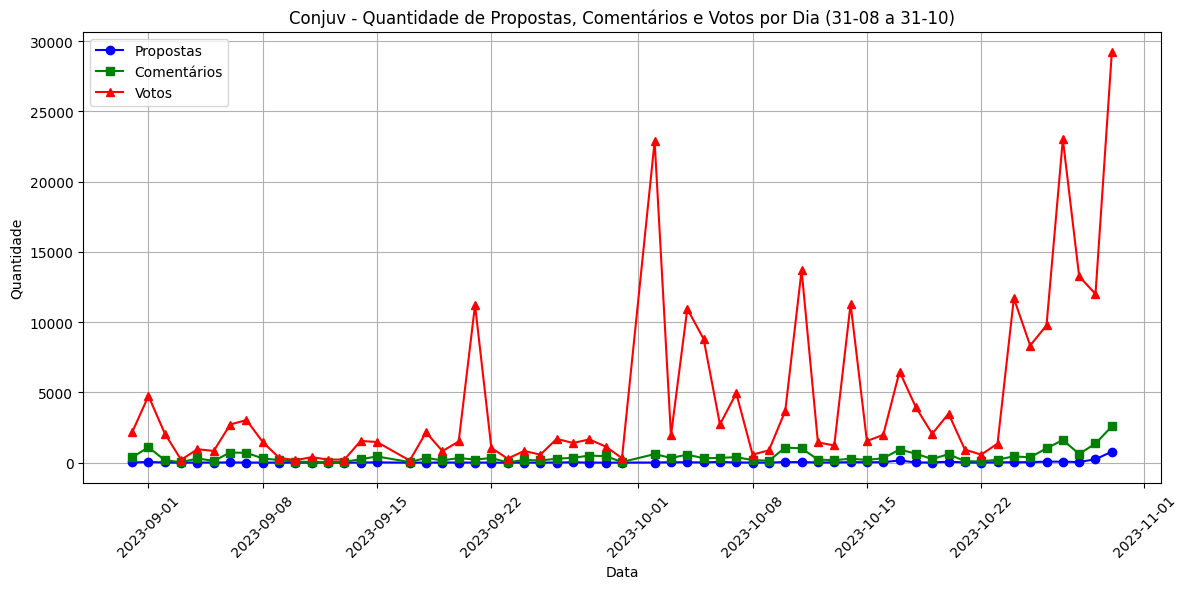

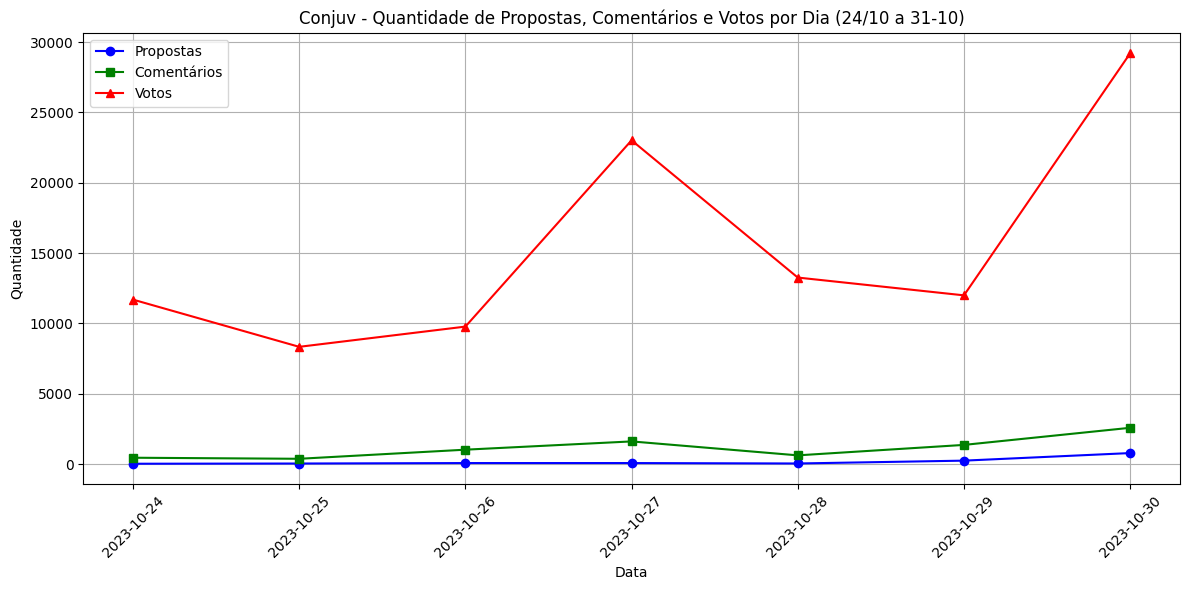

In [37]:
# grafico geral
df_propostas['published_at'] = pd.to_datetime(df_propostas['published_at'], format='%Y-%m-%d %H:%M:%S %z')
new_df_propostas = df_propostas[(df_propostas['published_at'] >= data_inicio_geral) & (df_propostas['published_at'] <= data_atual)].copy()
new_df_propostas['Data'] = new_df_propostas['published_at'].dt.date
n_propostas_dia = new_df_propostas.groupby('Data')['id'].count()
n_comentarios_dia = new_df_propostas.groupby('Data')['comments'].sum()
n_votos_dia = new_df_propostas.groupby('Data')['supports'].sum()

plt.figure(figsize=(12, 6))
plt.plot(n_propostas_dia.index, n_propostas_dia.values, label='Propostas', color='blue', marker='o')
plt.plot(n_comentarios_dia.index, n_comentarios_dia.values, label='Comentários', color='green', marker='s')
plt.plot(n_votos_dia.index, n_votos_dia.values, label='Votos', color='red', marker='^')

plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.title(f'Conjuv - Quantidade de Propostas, Comentários e Votos por Dia ({data_geral} a {data_formatada})')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f"relatorio_{data_formatada}/assets/conjuv_grafico_geral.png")

#grafico semana
df_propostas_semana['published_at'] = pd.to_datetime(df_propostas['published_at'], format='%Y-%m-%d %H:%M:%S %z')
new_df_propostas = df_propostas_semana[(df_propostas_semana['published_at'] >= data_inicio_geral) & (df_propostas_semana['published_at'] <= data_atual)].copy()
new_df_propostas['Data'] = new_df_propostas['published_at'].dt.date
n_propostas_dia = new_df_propostas.groupby('Data')['id'].count()
n_comentarios_dia = new_df_propostas.groupby('Data')['comments'].sum()
n_votos_dia = new_df_propostas.groupby('Data')['supports'].sum()

plt.figure(figsize=(12, 6))
plt.plot(n_propostas_dia.index, n_propostas_dia.values, label='Propostas', color='blue', marker='o')
plt.plot(n_comentarios_dia.index, n_comentarios_dia.values, label='Comentários', color='green', marker='s')
plt.plot(n_votos_dia.index, n_votos_dia.values, label='Votos', color='red', marker='^')


plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.title(f'Conjuv - Quantidade de Propostas, Comentários e Votos por Dia ({data_semana2} a {data_formatada})')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f"relatorio_{data_formatada}/assets/conjuv_grafico_semana.png")


### mapa de calor

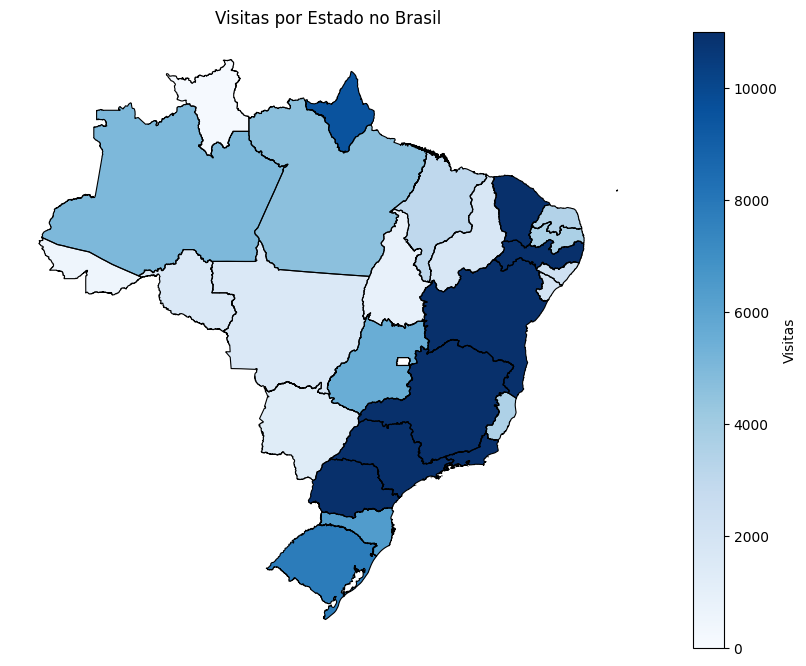

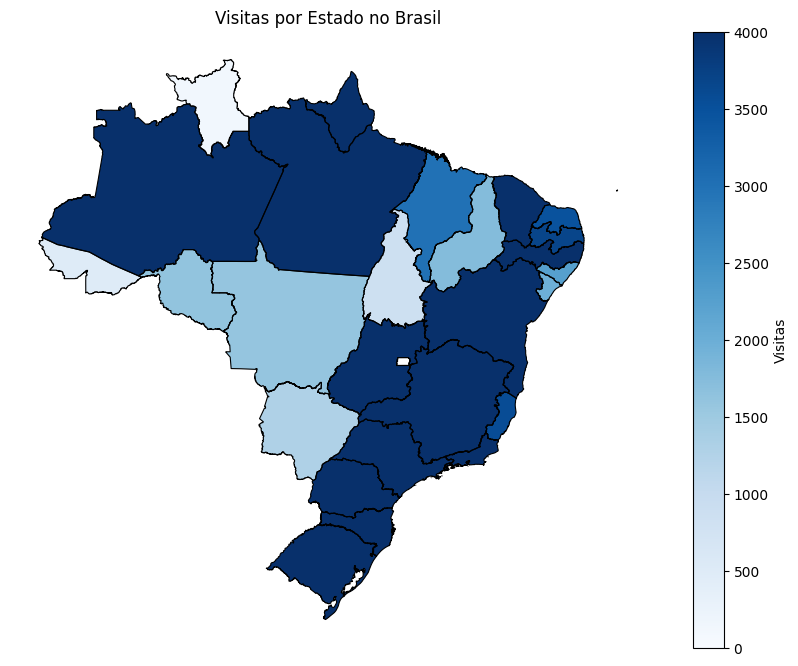

In [38]:
# mapa geral
shapefile_path = os.path.abspath(os.getcwd())

# Caminho relativo para o arquivo shapefile
shapefile_path = os.path.join(shapefile_path, 'shapefile', 'estados_2010.shp')
gdf = gpd.read_file(shapefile_path, encoding='ISO-8859-1')
mapa_path = f"relatorio_{data_formatada}/data/regiao_conjuv.csv"
df_mapa = pd.read_csv(mapa_path, sep='\t', encoding='utf-8')
gdf = gdf.merge(df_mapa, left_on='nome', right_on='Rótulo', how='left')
fig, ax = plt.subplots(figsize=(12, 8))
vmin, vmax = 0, 11000
gdf.boundary.plot(ax=ax, linewidth=0.8, color='k')
gdf.plot(column='Visitas', ax=ax, cmap='Blues', legend=True, legend_kwds={'label': "Visitas"}, vmin=vmin, vmax=vmax)
plt.title("Visitas por Estado no Brasil")
plt.axis('off')
plt.savefig(f"relatorio_{data_formatada}/assets/conjuv_regiao_geral.png")
plt.show()

df_mapa['Visitas'] = pd.to_numeric(df_mapa['Visitas'], errors='coerce')
indice_estado_mais_visitas = df_mapa['Visitas'].idxmax()
estado_mais_visitas = df_mapa.loc[indice_estado_mais_visitas, 'Rótulo']
indice_estado_menos_visitas = df_mapa['Visitas'].idxmin()
estado_menos_visitas = df_mapa.loc[indice_estado_menos_visitas, 'Rótulo']

# mapa semana
mapa_path = f"relatorio_{data_formatada}/data/regiao_conjuv_semana.csv"
df_mapa = pd.read_csv(mapa_path, sep='\t', encoding='utf-8')
gdf = gdf.merge(df_mapa, left_on='nome', right_on='Rótulo', how='left')
fig, ax = plt.subplots(figsize=(12, 8))
vmin, vmax = 0, 4000
gdf.boundary.plot(ax=ax, linewidth=0.8, color='k')
gdf.plot(column='Visitas_x', ax=ax, cmap='Blues', legend=True, legend_kwds={'label': "Visitas"}, vmin=vmin, vmax=vmax)
plt.title("Visitas por Estado no Brasil")
plt.axis('off')
plt.savefig(f"relatorio_{data_formatada}/assets/conjuv_regiao_semana.png")
plt.show()

df_mapa['Visitas'] = pd.to_numeric(df_mapa['Visitas'], errors='coerce')

indice_estado_mais_visitas2 = df_mapa['Visitas'].idxmax()
estado_mais_visitas2 = df_mapa.loc[indice_estado_mais_visitas2, 'Rótulo']

indice_estado_menos_visitas2 = df_mapa['Visitas'].idxmin()
estado_menos_visitas = df_mapa.loc[indice_estado_menos_visitas2, 'Rótulo']

#### usuarios novos e antigos


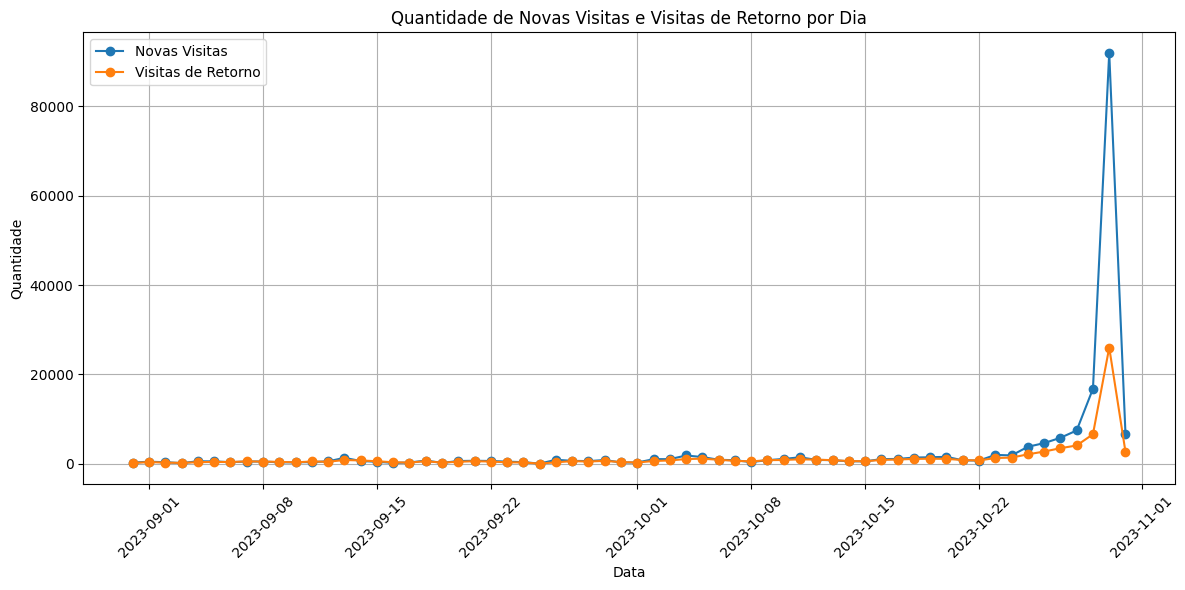

C:\Users\leibr\AppData\Local\Temp\ipykernel_2828\1081823711.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acessos_semana['Data'] = pd.to_datetime(df_acessos['Data'], format='%d/%m/%Y')


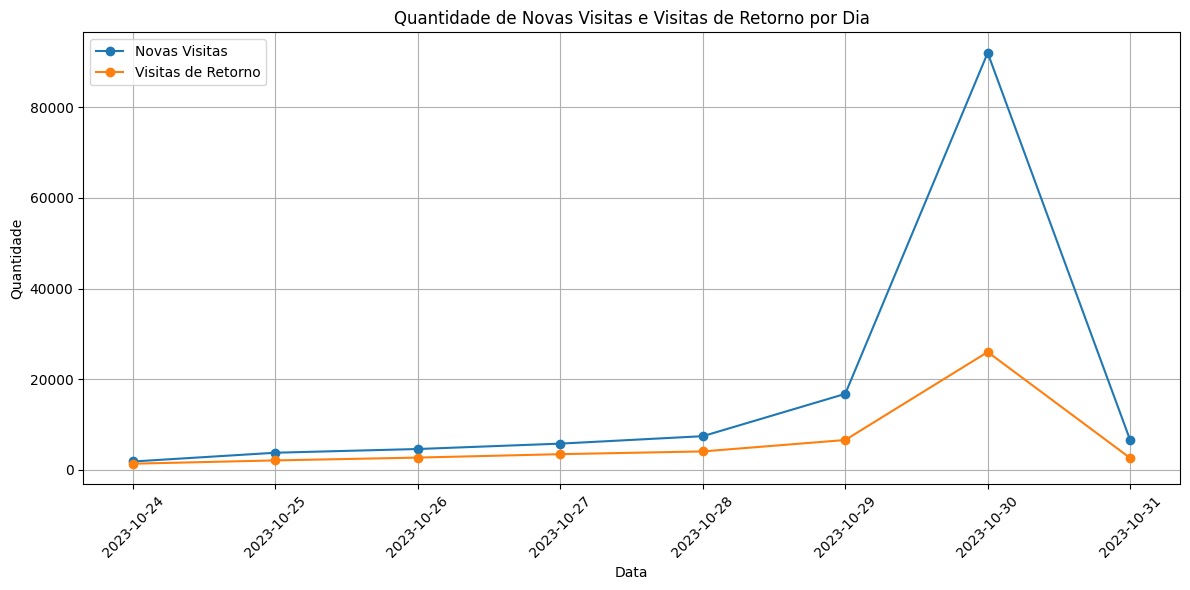

In [39]:
# dados totais
df_acessos['Data'] = pd.to_datetime(df_acessos['Data'], format='%d/%m/%Y')
agrupado_por_data = df_acessos.groupby('Data')[['Novas visitas', 'Visitas de retorno']].sum()
plt.figure(figsize=(12, 6))
plt.plot(agrupado_por_data.index, agrupado_por_data['Novas visitas'], label='Novas Visitas', marker='o')
plt.plot(agrupado_por_data.index, agrupado_por_data['Visitas de retorno'], label='Visitas de Retorno', marker='o')
plt.title('Quantidade de Novas Visitas e Visitas de Retorno por Dia')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"relatorio_{data_formatada}/assets/participantes.png")

plt.show()

# dados semana
df_acessos_semana['Data'] = pd.to_datetime(df_acessos['Data'], format='%d/%m/%Y')
agrupado_por_data = df_acessos_semana.groupby('Data')[['Novas visitas', 'Visitas de retorno']].sum()
plt.figure(figsize=(12, 6))
plt.plot(agrupado_por_data.index, agrupado_por_data['Novas visitas'], label='Novas Visitas', marker='o')
plt.plot(agrupado_por_data.index, agrupado_por_data['Visitas de retorno'], label='Visitas de Retorno', marker='o')
plt.title('Quantidade de Novas Visitas e Visitas de Retorno por Dia')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"relatorio_{data_formatada}/assets/participantes_semana.png")
plt.show()


### top 20


In [40]:
df_propostas = df_propostas.sort_values(by='supports', ascending=False)
top_20 = df_propostas.head(20)
ranking = top_20[['id', 'title/pt-BR', 'category/name/pt-BR', 'supports', 'comments']].copy()
ranking.columns = ['ID', 'Propostas', 'Temas', 'Nº de Votos', 'Nº de Comentários']

base_url = "http://brasilparticipativo.presidencia.gov.br/assemblies/confjuv4/f/10/proposals/"

def create_link(proposal_id, proposal_name):
    url = f"{base_url}{proposal_id}"
    return f"[{proposal_name}]({url})"

# Aplicar a função para criar os links na coluna 'Propostas'
ranking['Propostas'] = ranking.apply(lambda row: create_link(row['ID'], row['Propostas']), axis=1)

ranking = ranking.to_markdown(index=False)

### análise quantitativa


In [41]:
temas_df = df_propostas.groupby('category/name/pt-BR').agg({
    'title/pt-BR': 'nunique',  
    'supports': 'sum',        
    'comments': 'sum'        
}).reset_index()

temas_df = temas_df.sort_values(by='supports', ascending=False)
temas_df.columns = ['Temas', 'Nº de Propostas', 'Nº de Votos', 'Nº de Comentários']

temas_df = temas_df.to_markdown(index=False)

total_propostas = len(df_propostas)
propostas_acima_de_300_votos = len(df_propostas[df_propostas['supports'] > 300])
propostas_abaixo_de_20_votos = len(df_propostas[df_propostas['supports'] < 20])
porcentagem_abaixo_de_20_votos = (propostas_abaixo_de_20_votos / total_propostas) * 100

#### dados participantes


In [42]:
total_de_participantes = len(df_participantes)
participantes_10_pontos_ou_menos = len(df_participantes[df_participantes['Pontuação total'] <= 10.0])
participantes_10_a_20_pontos = len(df_participantes[(df_participantes['Pontuação total'] > 10.0) & (df_participantes['Pontuação total'] <= 20.0)])
participantes_20_a_50_pontos = len(df_participantes[(df_participantes['Pontuação total'] > 20.0) & (df_participantes['Pontuação total'] <= 50.0)])
participantes_mais_de_100_pontos = len(df_participantes[df_participantes['Pontuação total'] > 100.0])
tabela_resumo = pd.DataFrame({
    'Total de Participantes': [total_de_participantes],
    'Participantes com 10 pontos ou menos': [participantes_10_pontos_ou_menos],
    'Participantes com 10 a 20 pontos': [participantes_10_a_20_pontos],
    'Participantes com 20 a 50 pontos': [participantes_20_a_50_pontos],
    'Participantes com mais de 100 pontos': [participantes_mais_de_100_pontos]
})

tabela_resumo = tabela_resumo.to_markdown(index=False)

### dispositivos

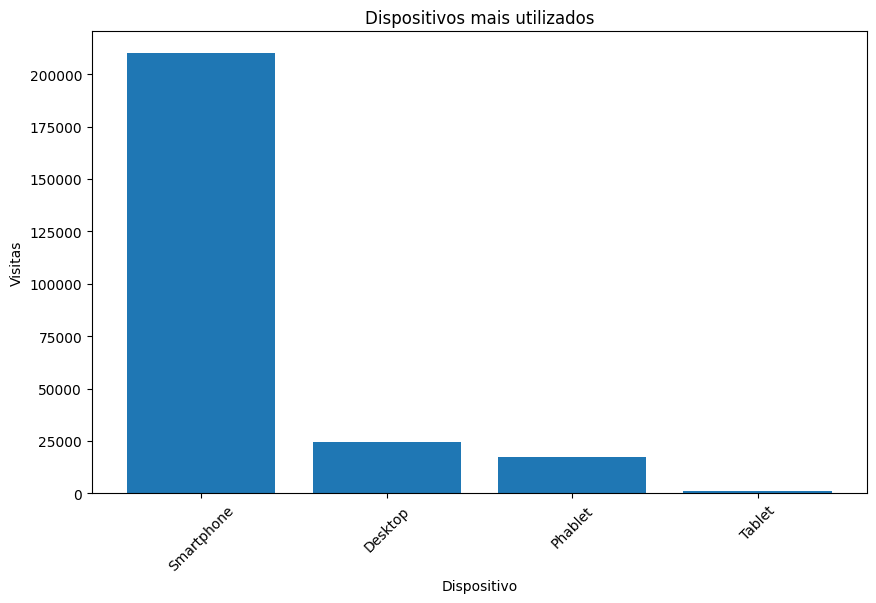

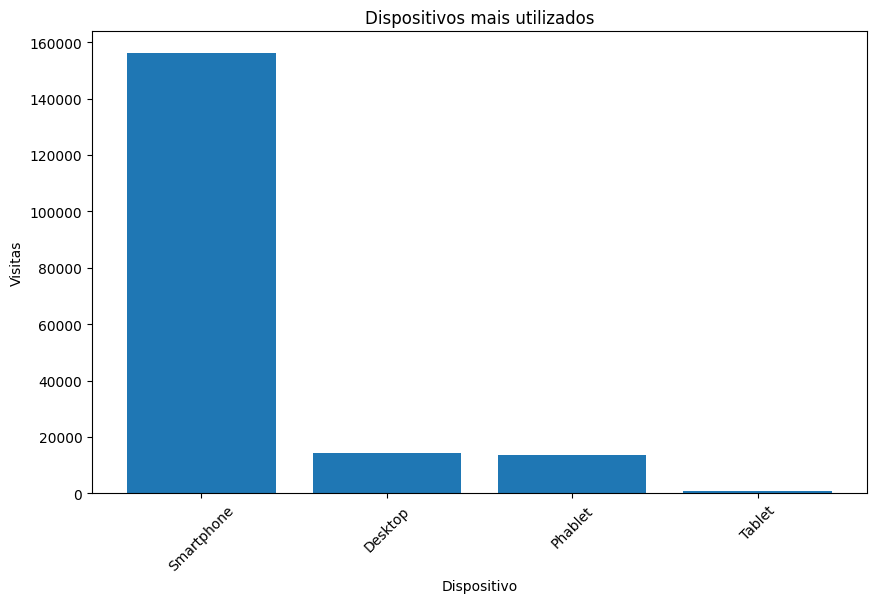

In [43]:
# Carregar o arquivo CSV em um DataFrame do Pandas
df_dispositivos = pd.read_csv(f"relatorio_{data_formatada}/data/dispositivo_conjuv.csv", sep=',', encoding='utf-16-le')

# Ordenar o DataFrame pela coluna 'Visitas' em ordem decrescente
df_dispositivos = df_dispositivos.sort_values(by='Visitas', ascending=False)

# Selecionar os top 5 dispositivos com base na coluna 'Rótulo'
top_5_dispositivos = df_dispositivos.head(4)

# Criar o gráfico de colunas
plt.figure(figsize=(10, 6))
plt.bar(top_5_dispositivos['Rótulo'], top_5_dispositivos['Visitas'])
plt.xlabel('Dispositivo')
plt.ylabel('Visitas')
plt.title('Dispositivos mais utilizados')
plt.xticks(rotation=45)  # Rotação dos rótulos no eixo x para melhor legibilidade
plt.savefig(f"relatorio_{data_formatada}/assets/dispositivos.png")

# Mostrar o gráfico
plt.show()

# Carregar o arquivo CSV em um DataFrame do Pandas
df_dispositivos = pd.read_csv(f"relatorio_{data_formatada}/data/dispositivo_conjuv_semana.csv", sep=',', encoding='utf-16-le')

# Ordenar o DataFrame pela coluna 'Visitas' em ordem decrescente
df_dispositivos = df_dispositivos.sort_values(by='Visitas', ascending=False)

# Selecionar os top 5 dispositivos com base na coluna 'Rótulo'
top_5_dispositivos = df_dispositivos.head(4)

# Criar o gráfico de colunas
plt.figure(figsize=(10, 6))
plt.bar(top_5_dispositivos['Rótulo'], top_5_dispositivos['Visitas'])
plt.xlabel('Dispositivo')
plt.ylabel('Visitas')
plt.title('Dispositivos mais utilizados')
plt.xticks(rotation=45)  # Rotação dos rótulos no eixo x para melhor legibilidade
plt.savefig(f"relatorio_{data_formatada}/assets/dispositivos_semana.png")

# Mostrar o gráfico
plt.show()

#### markdown


In [44]:
with open('textos.yml', 'r', encoding='utf-8') as arquivo_yaml:
    dados = yaml.load(arquivo_yaml, Loader=yaml.FullLoader)

data_formatada = date.today().strftime('%d-%m')

titulo = f"<center>Relatório Conjuv ({data_formatada})</center>"

with open(f'relatorio_{data_formatada}/relatorio_conjuv_{data_formatada}.md', 'w', encoding='utf-8') as report_file:
    report_file.write(f"# {titulo}\n\n")
    report_file.write("\n# Sumário:\n")
    report_file.write("- [Introdução](#introdução)\n")
    report_file.write("- [Dados Totais](#dados-totais)\n")
    report_file.write("- [Dados de Acesso](#dados-de-acesso)\n")
    report_file.write("- [Perfil do Visitantes](#perfil-do-visitante)\n")
    report_file.write("- [TOP 20 Propostas](#top-20-propostas)\n")
    report_file.write("- [Análise Qualitativa](#análise-qualitativa)\n")
    report_file.write("- [Dados dos Participantes](#dados-dos-participantes)\n\n")

    report_file.write("## Introdução\n\n")
    report_file.write(f"{dados['introducao'][0]}\n\n")
    report_file.write("## Dados Totais\n\n")
    report_file.write(f"{dados['dados_gerais'][0]}\n\n")
    report_file.write(f'### *Dados Totais da Conjuv (Geral)*\n\n{dados_totais}\n\n')
    report_file.write(f'### *Dados Totais da Conjuv (Semanal)*\n\n{dados_semana}\n\n\n')
    report_file.write(f"### *Qtd de Propostas, Votos e Comentários (Período Completo)*\n\n\n")
    report_file.write(f"Esse gráfico mostra o comportamento da quantidade total de Propostas, Votos e comentários do dia {data_geral2} até {data_formatada2}.\n\n\n")
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../../relatorio_{data_formatada}/assets/conjuv_grafico_geral.png"\n alt="Descrição do Gráfico 1"/>\n')
    report_file.write('</p>\n\n')
    report_file.write(f"### *Qtd de Propostas, Votos e Comentários (Semana)*\n\n\n")
    report_file.write(f"Esse gráfico mostra o comportamento da quantidade total de Propostas, Votos e comentários do dia {data_semana2} até {data_formatada2}.\n\n\n")
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../../relatorio_{data_formatada}/assets/conjuv_grafico_semana.png"\n alt="Descrição do Gráfico 1"/>\n')
    report_file.write('</p>\n\n')

    report_file.write("## Dados de Acesso\n\n")
    report_file.write(f"{dados['dados_acesso'][0]}\n\n\n")
    report_file.write(f'### *Dados de Acesso (Geral)*\n\n\n{acessos}\n\n\n')
    report_file.write(f'### *Dados de Acesso (Semanal)*\n\n\n{acessos_semana}\n\n\n')
    report_file.write(f"{dados['dados_visitantes'][0]}\n\n")
    report_file.write(f'### *Visitantes novos e Visitantes de Retorno (Geral)*\n\n\n')
    report_file.write('\n<p align="center">\n')
    report_file.write(f'  <img src="../../relatorio_{data_formatada}/assets/participantes.png"\n alt=" Exemplo de um Painel de Visitante"/>\n')
    report_file.write('</p>\n\n')
    report_file.write(f'### *Visitantes novos e Visitantes de Retorno (Semana)*\n\n\n')
    report_file.write('\n<p align="center">\n')
    report_file.write(f'  <img src="../../relatorio_{data_formatada}/assets/participantes_semana.png"\n alt=" Exemplo de um Painel de Visitante"/>\n')
    report_file.write('</p>\n\n')
    report_file.write(f"{dados['rodape'][0]}\n\n\n")

    report_file.write("## Perfil do Visitante\n\n")
    report_file.write(f"{dados['perfil_visitante'][0]}\n\n")
    report_file.write('\n<p align="center">\n')
    report_file.write(f'  <img src=".../../conjuv/painel_visitante.png"\n alt=" Exemplo de um Painel de Visitante"/>\n')
    report_file.write('</p>\n\n')

    report_file.write(f"### *Mapa com a Qtd de visitas por UF (Geral)*\n")
    report_file.write(f"Esse mapa explica a quantidade de acessos por Unidade Federativa do Brasil, do dia {data_geral2} até {data_formatada2}.\n\n\n")

    report_file.write(f"{dados['mapa_1'][0]}\n\n")
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../../relatorio_{data_formatada}/assets/conjuv_regiao_geral.png"\n alt="Descrição do Gráfico 2"/>\n')
    report_file.write('</p>\n\n')

    report_file.write(f"### *Mapa com a Qtd de visitas por UF (Semanal)*\n")
    report_file.write(f"Esse mapa explica a quantidade de acessos por Unidade Federativa do Brasil, do dia {data_semana2} até {data_formatada2}.\n\n\n")
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../../relatorio_{data_formatada}/assets/conjuv_regiao_semana.png"\n alt="Descrição do Gráfico 2"/>\n')
    report_file.write('</p>\n\n')

    report_file.write('### *Dispositivos*\n\n')
    report_file.write(f"{dados['dispositivos'][0]}\n\n")

    report_file.write("### *Tipos de Dispositivos (Geral)*\n\n\n")
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../../relatorio_{data_formatada}/dispositivos.png"\n alt="Descrição do Gráfico 2"/>\n')
    report_file.write('</p>\n\n')
    report_file.write("### *Tipos de Dispositivos (Semanal)*\n\n\n")
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../../relatorio_{data_formatada}/dispositivos_semana.png"\n alt="Descrição do Gráfico 2"/>\n')
    report_file.write('</p>\n\n')

    report_file.write("## Top 20 Propostas\n\n")
    report_file.write(f"{dados['top_20_propostas'][0]}\n\n")
    report_file.write(f"{ranking}\n\n")
    report_file.write("## Analise Qualitativa\n\n")
    report_file.write(f"{dados['temas'][0]}\n\n")
    report_file.write(f"{temas_df}\n\n")
    report_file.write(f"- De {total_propostas} propostas atuais, apenas {propostas_acima_de_300_votos} delas apresentam votação acima de 300;\n")
    report_file.write(f"- {propostas_abaixo_de_20_votos} propostas estão com menos de 20 votos ({porcentagem_abaixo_de_20_votos:.2f}% do total de propostas);\n\n")

    report_file.write("## Dados dos Participantes\n\n")
    report_file.write(f"{dados['participantes'][0]}\n\n")
    report_file.write(f"{tabela_resumo}\n\n")